# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

## Lane Finding Pipeline



In [2]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def stack_images(img_a, img_b):
    return np.hstack((img_a, img_b))

def show_image(img):
    plt.figure(figsize = (15, 10))
    plt.imshow(img)
    
def show_gray_image(img):
    plt.figure(figsize = (15, 10))
    plt.imshow(img, cmap='gray')
    
def plot_start():
    plt.figure(figsize = (15, 10))
    
def plot_lines(lines, color):
    for line in lines:
        for x1, y1, x2, y2 in line:
            plt.plot((x1, x2), (y1, y2), color)
        
def plot_function(f, xs):
    for x in range(xs[0], xs[len(xs) - 1]):
        plt.plot(x, f(x), 'g2')

In [3]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def crop(image, top_left, top_right, bottom_right, bottom_left):
    roi = [np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.int32)]
    return region_of_interest(image, roi)

def crop_by_ref(img, ref_width, ref_height, ref_top_x, ref_top_y, ref_bot_x, ref_bot_y):
    width = image.shape[1]
    image_height = image.shape[0]
    middle_x = int(width / 2)
    image_offset_bottom_x = int(width * ref_bot_x / ref_width)
    image_offset_bottom_y = int(image_height * ref_bot_y / ref_height)
    image_offset_top_x = int(width * ref_top_x / ref_width)
    image_offset_top_y = int(image_height * ref_top_y / ref_height)
    top_left = [middle_x - image_offset_top_x, image_offset_top_y]
    top_right = [middle_x + image_offset_top_x, image_offset_top_y]
    bottom_right = [width - image_offset_bottom_x, image_offset_bottom_y]
    bottom_left = [image_offset_bottom_x, image_offset_bottom_y]

    return crop(img, top_left, top_right, bottom_right, bottom_left)

In [4]:
def equalize_histogram(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def clache(img):
    cl = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8, 8))
    
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(img_yuv)
    y_clache = cl.apply(y)
    img_yuv = cv2.merge((y_clache, u, v))
    
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR) 

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [5]:
def binary_hsv_mask(img, color_range):
    lower = np.array(color_range[0])
    upper = np.array(color_range[1])

    return cv2.inRange(img, lower, upper)

def binary_gray_mask(img, color_range):
    lower = np.array(color_range[0])
    upper = np.array(color_range[1])

    return cv2.inRange(img, color_range[0][0], color_range[1][0])

def binary_mask_apply(img, binary_mask):
    masked_image = np.zeros_like(img)
    
    for i in range(3): 
        masked_image[:,:,i] = binary_mask.copy()
        
    return masked_image

def binary_mask_apply_color(img, binary_mask):
    return cv2.bitwise_and(img, img, mask = binary_mask)

def filter_by_color_ranges(img, color_ranges):
    result = np.zeros_like(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    for color_range in color_ranges:
        color_bottom = color_range[0]
        color_top = color_range[1]
        
        if color_bottom[0] == color_bottom[1] == color_bottom[2] and color_top[0] == color_top[1] == color_top[2]:
            mask = binary_gray_mask(gray_img, color_range)
        else:
            mask = binary_hsv_mask(hsv_img, color_range)
            
        masked_img = binary_mask_apply(img, mask)
        result = cv2.addWeighted(masked_img, 1.0, result, 1.0, 0.0)

    return result

In [178]:
def hough_lines(image):
    return cv2.HoughLinesP(image, 2, np.pi / 180, 50, np.array([]), 20, 70)

def left_right_lines(lines):
    lines_all_left = []
    lines_all_right = []
    slopes_left = []
    slopes_right = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            
            if slope > 0:
                lines_all_right.append(line)
                slopes_right.append(slope)
            else:
                lines_all_left.append(line)
                slopes_left.append(slope)
                
    return [[lines_all_left, slopes_left], [lines_all_right, slopes_right]]
    
def filter_lines_outliers(lines, slopes, min_slope = 0.5, max_slope = 0.9):
    if len(lines) == 0 or len(slopes) == 0:
        return []
    elif len(lines) == 1:
        return lines
    
    lines_no_outliers = []
    slopes_no_outliers = []
    
    for i, line in enumerate(lines):
        slope = slopes[i]
        
        if min_slope < abs(slope) < max_slope:
            lines_no_outliers.append(line)
            slopes_no_outliers.append(slope)
          
    slope_median = np.average(slopes_no_outliers)
    slope_std_deviation = np.std(slopes_no_outliers)
    filtered_lines = []
    
    for i, line in enumerate(lines_no_outliers):
        slope = slopes_no_outliers[i]
        
        if slope_median - 2 * slope_std_deviation < slope < slope_median + 2 * slope_std_deviation:
             filtered_lines.append(line)

    return filtered_lines

def median(lines, prev_ms, prev_bs):
    if prev_ms is None:
        prev_ms = []
        prev_bs = []
        
    xs = []
    ys = []
    xs_med = []
    ys_med = []
    m = 0
    b = 0

    for line in lines:
        for x1, y1, x2, y2 in line:
            xs += [x1, x2]
            ys += [y1, y2]

    if len(xs) > 0 and len(ys) > 0:
        m, b = np.polyfit(xs, ys, 1)
        
        if len(prev_ms) > 0 and len(prev_bs) > 0:
            prev_ms_average = np.average(prev_ms)
            prev_ms_std_deviation = np.std(prev_ms) * 3

            prev_bs_average = np.average(prev_bs)
            prev_bs_std_deviation = np.std(prev_bs) * 3

#             if prev_ms_average - prev_ms_std_deviation < m < prev_ms_average + prev_ms_std_deviation:
#             if prev_bs_average - prev_bs_std_deviation < b < prev_bs_average + prev_bs_std_deviation:
            prev_ms.append(m)
            prev_bs.append(b)
        else:
            return np.poly1d([m, b])
    
    if m == 0 and len(prev_ms) == 0:
        return None
    else:
        return np.poly1d([np.average(prev_ms), np.average(prev_bs)])

def intersect(f_a, f_b, bottom_y):
    intersect_x = 0
    intersect_y = 0
    
    left_x = int((f_a - bottom_y).roots)
    right_x = int((f_b - bottom_y).roots)

    m_left = f_a.c[0]
    b_left = f_a.c[1]
    
    m_right = f_b.c[0]
    b_right = f_b.c[1]

    intersect_x = (b_right - b_left) / (m_left - m_right)
    intersect_y = intersect_x * m_right + b_right
    
    return [int(intersect_x), int(intersect_y)]

In [179]:
def draw_lanes(height, width, left_x, right_x, bottom_y, intersect_pt):
    line_img = np.zeros((height, width, 3), dtype=np.uint8)

    if left_x != 0 and intersect_pt[0] != 0 and intersect_pt[1] != 0:
        cv2.line(line_img, (left_x, bottom_y), (intersect_pt[0], intersect_pt[1]), [255, 0, 0], 5)

    if right_x != 0 and intersect_pt[0] != 0 and intersect_pt[1] != 0:
        cv2.line(line_img, (intersect_pt[0], intersect_pt[1]), (right_x, bottom_y), [0, 255, 0], 5)

    if left_x != 0 and right_x != 0:
        cv2.line(line_img, (left_x, bottom_y), (right_x, bottom_y), [0, 0, 255], 5)
        
    return line_img

In [180]:
def detect(image, white_value, prev_left_ms, prev_left_bs, prev_right_ms, prev_right_bs):
    if white_value < 150:
        return [None, None, None, None]
    
    #----------------------------- COLOR THRESHOLD ---------------------------
    white = [[white_value, white_value, white_value], [255, 255, 255]]
    yellow = [[80, 90, 90], [120, 255, 255]]
    image_masked = filter_by_color_ranges(image, [white, yellow])

    #----------------------------- EDGES ---------------------------
    gray_img = cv2.cvtColor(image_masked, cv2.COLOR_BGR2GRAY)
    v = np.median(gray_img)
    sigma = 0.33
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))

    image_edges = canny(image_masked, lower, upper)

    #----------------------------- HOUGH ---------------------------
    houghed_lns = hough_lines(image_edges)
    
    if houghed_lns is None:
        return detect(image, white_value - 5, prev_left_ms, prev_left_bs, prev_right_ms, prev_right_bs)
    
    left_hough, right_hough = left_right_lines(houghed_lns)
    left_lns, left_slopes = left_hough
    right_lns, right_slopes = right_hough

    filtered_left_lns = filter_lines_outliers(left_lns, left_slopes)
    filtered_right_lns = filter_lines_outliers(right_lns, right_slopes)
    
    median_left_f = median(filtered_left_lns, prev_left_ms, prev_left_bs)
    median_right_f = median(filtered_right_lns, prev_right_ms, prev_right_bs)
    
    if median_left_f is None or median_right_f is None:
        return detect(image, white_value - 5, prev_left_ms, prev_left_bs, prev_right_ms, prev_right_bs)
    else:
        return [left_lns, right_lns, median_left_f, median_right_f]

def image_pipeline(image, prev_left_ms, prev_left_bs, prev_right_ms, prev_right_bs, should_plot = False):
    #----------------------------- CROP ---------------------------
    ref_width = 960
    ref_height = 540
    ref_top_x = 50
    ref_top_y = 310
    ref_bottom_x = 70
    ref_bottom_y = 510
    image_cropped = crop_by_ref(image, ref_width, ref_height, ref_top_x, ref_top_y, ref_bottom_x, ref_bottom_y)
    
    #----------------------------- COLOR CORRECT ---------------------------
    blured = cv2.bilateralFilter(image_cropped, 11, 75, 75)
    unsharp_image = cv2.addWeighted(blured, 1.5, blured, -0.5, 0, image_cropped)
    image_clached = clache(unsharp_image)

    #----------------------------- HOUGH ---------------------------
    left_lns, right_lns, median_left_f, median_right_f = detect(image_clached, 220, prev_left_ms, prev_left_bs, prev_right_ms, prev_right_bs)
    
    if median_left_f is None and median_right_f is None:
        return [image, None, None]

    bottom_y = image.shape[0]
    intersect_pt = intersect(median_left_f, median_right_f, bottom_y)
    
    left_x = int((median_left_f - bottom_y).roots)
    right_x = int((median_right_f - bottom_y).roots)
    
    if should_plot:
        plot_start()
        plot_lines(left_lns, 'r')
        plot_lines(right_lns, 'b')
    
        if median_left_f is not None:
            plot_function(median_left_f, [left_x, intersect_pt[0]])
        
        if median_right_f is not None:
            plot_function(median_right_f, [intersect_pt[0], right_x])
    
    #----------------------------- DRAW ---------------------------
    lanes = draw_lanes(image.shape[0], image.shape[1], left_x, right_x, bottom_y, intersect_pt)
    return [weighted_img(lanes, image), median_left_f, median_right_f]

In [202]:
os.listdir("test_images/")

['.DS_Store',
 'challenge1.jpg',
 'challenge2.jpg',
 'challenge3.jpg',
 'challenge4.jpg',
 'challenge5.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'whiteCarLaneSwitch.jpg']

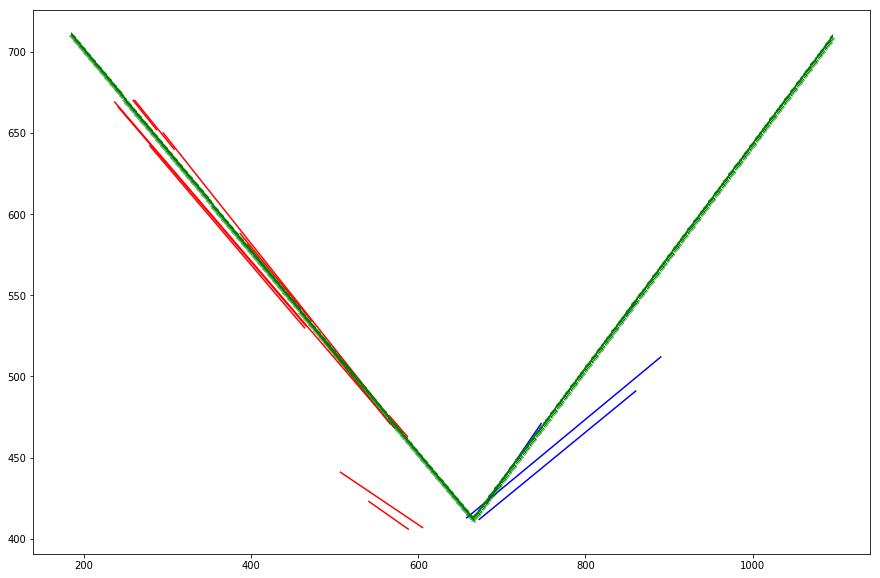

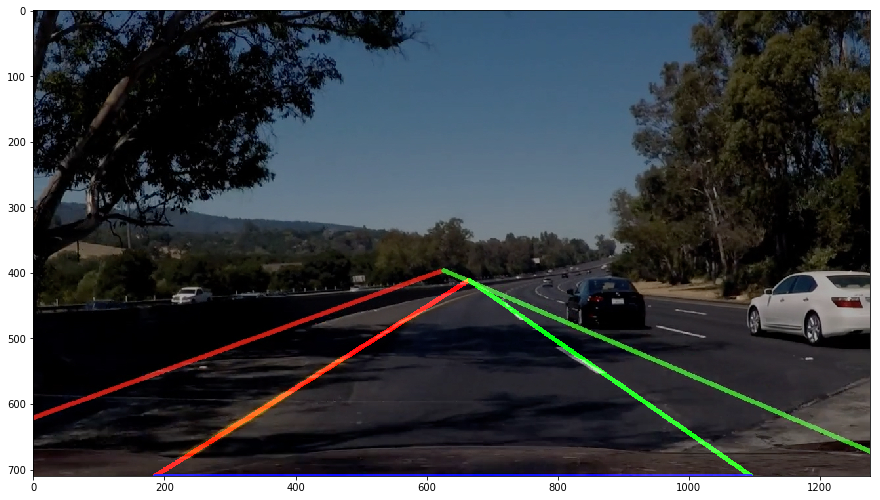

In [204]:
image = mpimg.imread('test_images/challenge5.jpg')
image, left_f, right_f = image_pipeline(image, [], [], [], [], True)
show_image(image)

In [115]:
for img in os.listdir('test_images/'):
    if img.endswith('jpg'):
        image = mpimg.imread('test_images/{}'.format(img))
        image, left_f, right_f = image_pipeline(image, [], [], [], [])
        
        plt.figure(figsize = (15, 10))
        mpimg.imsave('test_images_output/{}'.format(img), image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [183]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [205]:
class Lane(object):

    def __init__(self):
        self.left_fs = []
        self.right_fs = []
        
    def process_frame(self, frame):
        left_ms = []
        right_ms = []
        left_bs = []
        right_bs = []
        max_buffer_size = 0
        
        for i in range(len(self.left_fs)):
            m, b = self.left_fs[-i].coeffs
            left_ms.append(m)
            left_bs.append(b)
        
        for i in range(len(self.right_fs)):
            m, b = self.right_fs[-i].coeffs
            right_ms.append(m)
            right_bs.append(b)

        result, left_f, right_f = image_pipeline(frame, left_ms, left_bs, right_ms, right_bs)

        if left_f is not None:
            self.left_fs.append(left_f)
            
            if len(self.left_fs) > max_buffer_size:
                self.left_fs.pop(0)
            
        if right_f is not None:
            self.right_fs.append(right_f)
            
            if len(self.right_fs) > max_buffer_size:
                self.right_fs.pop(0)

        return result

In [189]:
lane = Lane()

white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane.process_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:31<00:00,  6.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1min 14s, sys: 2.76 s, total: 1min 16s
Wall time: 32.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [190]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [191]:
lane = Lane()

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lane.process_frame)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [02:02<00:00,  3.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 4min 3s, sys: 10.4 s, total: 4min 13s
Wall time: 2min 4s


In [192]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [206]:
lane = Lane()

challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(lane.process_frame)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [01:02<00:00,  3.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 2min 32s, sys: 5.13 s, total: 2min 37s
Wall time: 1min 4s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))